# Prediction with Machine Learning HW2
## Mukhamejan Assan

Business: Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market. 

Build a price prediction model similarly to how we did in our case study for London. 

Discuss your modeling decisions and compare your results to those of the case study. 


## Part I. Accessing and Cleaning Data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('listings.csv')
df.shape 

(11056, 75)

### The variables, their description, and type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11056 non-null  int64  
 1   listing_url                                   11056 non-null  object 
 2   scrape_id                                     11056 non-null  int64  
 3   last_scraped                                  11056 non-null  object 
 4   source                                        11056 non-null  object 
 5   name                                          11054 non-null  object 
 6   description                                   11018 non-null  object 
 7   neighborhood_overview                         7087 non-null   object 
 8   picture_url                                   11056 non-null  object 
 9   host_id                                       11056 non-null 

Some of the 73 variables may not be useful. 

1. Variables that cannot be changed:

    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name'

2. Variables that are not relevant because the listings have not yet been introduced into the market:

    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count','host_verifications','host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value'

In [4]:
df.shape

(11056, 75)

In [5]:
df.drop(
    ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name','host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood', 'host_listings_count', 'host_total_listings_count','host_verifications','host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location','review_scores_value'],
    inplace=True,
    axis=1
)

### EDA and sample definition and preparation

#### Encoding property type

We are only interested in apartments.
1. Check if property types are all indicated 
2. keep only apartments

In [6]:
print(df["property_type"].isnull().sum(), "property types are missing.")

0 property types are missing.


Property types do not seem to be well-defined. I will find the apartment listings by finding the `partment` in descriptions and then select the property types that say either "Entire" or "Home" but not "room".

In [7]:
print(df[df['description'].str.contains('partment',na=False)].property_type.value_counts())
df = df[df['description'].str.contains('partment',na=False)]

Entire rental unit                    4843
Entire condo                          1419
Private room in rental unit            192
Entire serviced apartment              175
Entire loft                             93
Entire home                             89
Room in aparthotel                      83
Private room in condo                   63
Room in serviced apartment              38
Private room in serviced apartment      26
Room in boutique hotel                  12
Entire vacation home                    11
Private room in guest suite             11
Shared room in rental unit              10
Entire guest suite                       9
Room in hotel                            8
Entire townhouse                         5
Tiny home                                4
Private room in bed and breakfast        3
Private room in vacation home            2
Entire villa                             2
Entire place                             2
Private room in hostel                   2
Private roo

In [8]:
# keeping only the apartments
df = df[df.property_type.apply(lambda x: ("Entire" in x or 'ome' in x) and 'room' not in x).to_list()]
# What is left in the end? 
df.property_type.value_counts()
# Still way too many categories. Focus on the 4 biggest, and give a sensible name to each. 
df = df[df['property_type'].apply(lambda x: x in ("Entire rental unit Entire condo Entire serviced apartment Entire loft"))]

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text
d = { "Entire rental unit": "Apartment", "Entire condo": "Condo", "Entire serviced apartment": "Serviced apartment","Entire loft" : "Loft"}

df['property_type'] = replace_all(df["property_type"], d)


In [9]:
df['property_type'].value_counts()

Apartment             4843
Condo                 1419
Serviced apartment     175
Loft                    93
Name: property_type, dtype: int64

Now, we need to limit our data to apartments which accomodate 2-6 people. 

In [10]:
df = df[df['accommodates'].between(2,6)]

In [11]:
# Since we are focusing only on apartments that can be entirely rented out, we will drop the room type column
print("Only", len(df['room_type'].unique()), "unique value for room_type")
df.drop('room_type', axis=1, inplace=True)

Only 1 unique value for room_type


#### Missing values

There are 17229 missing values in total


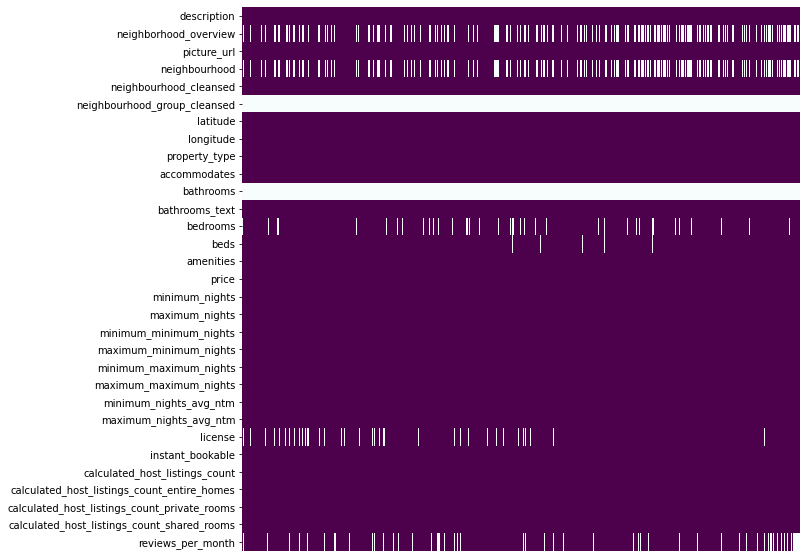

In [12]:
# Check for missing values frequency
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.isnull().T, xticklabels=False, cbar=False, cmap='BuPu_r', ax=ax)
print('There are', df.isna().sum().sum(), 'missing values in total')

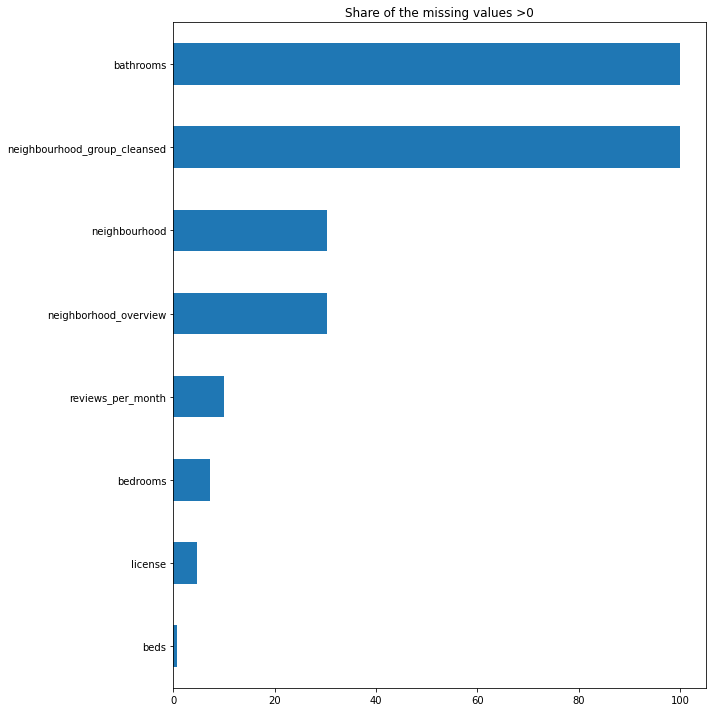

In [13]:
# focus on features with missing values
na_share = df.isnull().mean()*100
fig, ax = plt.subplots(figsize=(10,10))    
na_share[na_share>0].sort_values(ascending=True).plot.barh(title = 'Share of the missing values >0')
plt.tight_layout()

In [14]:
na_share[na_share>0].sort_values(ascending=False)

neighbourhood_group_cleansed    100.000000
bathrooms                       100.000000
neighborhood_overview            30.378289
neighbourhood                    30.378289
reviews_per_month                10.065789
bedrooms                          7.138158
license                           4.753289
beds                              0.657895
dtype: float64

In [15]:
df['price'] = df['price'].apply(lambda x: int(float(x.replace('$', '').replace(',',''))))
df['log_price'] = np.log(df['price'])

#### Encoding the neighborhoods

Since the data on neighborhoods is not clean, I am mapping the coordiantes of the listings to the electoral districts of Athens. My assumptions is that this division groups similar households/apartments. Data source: https://tipsforgis.wordpress.com/2018/09/26/leaflet-map-1/

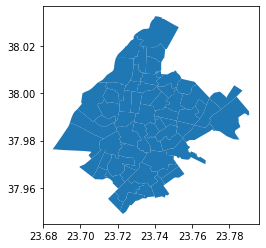

In [16]:
import geopandas as gpd

# Read the JSON file into a GeoDataFrame
data = gpd.read_file("daeklogikadiamerismata.json")

# Plot the GeoDataFrame
data.plot()

# Show the plot
plt.show()


In [17]:
from shapely.geometry import Point

# define a function to get the "fid" value for a given point
def get_fid(row):
    point = Point(row['longitude'], row['latitude'])
    for j, polygon in data.iterrows():
        if polygon["geometry"].contains(point):
            fid = polygon["fid"]
            return fid
    return None

# apply the function to create a new column in df with the "fid" values
df['fid'] = df.apply(get_fid, axis=1)

In [18]:
df['fid']

1        26.0
2        26.0
3        26.0
4        26.0
5        49.0
         ... 
11029    45.0
11030    59.0
11031    61.0
11051    45.0
11054    56.0
Name: fid, Length: 6080, dtype: float64

In [21]:
df[['price', 'fid', 'log_price']]

,price,fid,log_price
1,75,26.0,4.317488
2,60,26.0,4.094345
3,42,26.0,3.737670
4,75,26.0,4.317488
5,68,49.0,4.219508
...,...,...,...
11029,100,45.0,4.605170
11030,48,59.0,3.871201
11031,41,61.0,3.713572
11051,56,45.0,4.025352


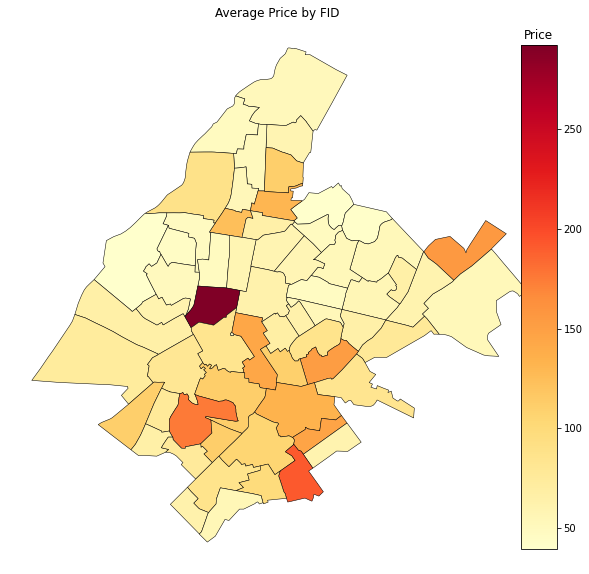

In [25]:
# Group the listings by fid and calculate the mean price
price_by_fid = df.groupby('fid')['price'].mean()

# Join the average prices back to the GeoDataFrame
data_with_price = data.join(price_by_fid, on='fid')

# Plot the average price by fid on the map
fig, ax = plt.subplots(figsize=(10,10))
data_with_price.plot(column='price', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='black')

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=data_with_price['price'].min(), vmax=data_with_price['price'].max()))
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04, ax=ax, cax=plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7]))
cbar.ax.set_title('Price')

ax.axis('off')
ax.set_title('Average Price by FID')
plt.show()

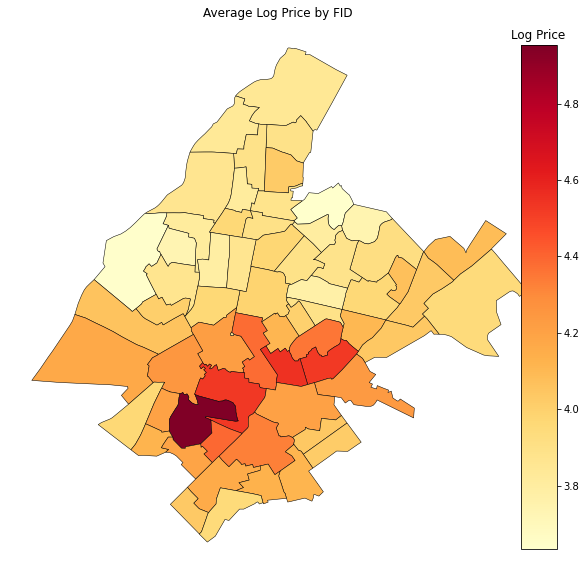

In [23]:
# Group the listings by fid and calculate the mean log price
log_price_by_fid = df.groupby('fid')['log_price'].mean()

# Join the average log prices back to the GeoDataFrame
data_with_log_price = data.join(log_price_by_fid, on='fid')

# Plot the average log price by fid on the map
fig, ax = plt.subplots(figsize=(10,10))
data_with_log_price.plot(column='log_price', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='black')

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=data_with_log_price['log_price'].min(), vmax=data_with_log_price['log_price'].max()))
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04, ax=ax, cax=plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7]))
cbar.ax.set_title('Log Price')

ax.axis('off')
ax.set_title('Average Log Price by FID')
plt.show()

Average log_price makes much more sense and looks like the location is affecting the price a lot. 

In [26]:
print("There are only", df['fid'].isna().sum(), "listings without an assigned district.")

There are only 4 listings without an assigned district.


#### Recovering the number of bathrooms

In [27]:
# Check how many instance have bathroom info missing
print(df['bathrooms_text'].isnull().sum(), "instances have missing information on bathrooms count")

# Define a dictionary that maps each bathroom value to its corresponding numeric value
bathroom_mapping = {'1 bath': 1, '1.5 baths': 1.5, '2 baths': 2, '2.5 baths': 2.5, '0 baths': 0, '3 baths': 3, '3.5 baths': 3.5, 'Half-bath': 0.5, '4 baths': 4}

# Replace the values in the 'bathrooms_text' column with their corresponding numeric values
df['bathrooms'] = df['bathrooms_text'].replace(bathroom_mapping)

0 instances have missing information on bathrooms count


#### Amenities

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6080 entries, 1 to 11054
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   description                                   6080 non-null   object 
 1   neighborhood_overview                         4233 non-null   object 
 2   picture_url                                   6080 non-null   object 
 3   neighbourhood                                 4233 non-null   object 
 4   neighbourhood_cleansed                        6080 non-null   object 
 5   neighbourhood_group_cleansed                  0 non-null      float64
 6   latitude                                      6080 non-null   float64
 7   longitude                                     6080 non-null   float64
 8   property_type                                 6080 non-null   object 
 9   accommodates                                  6080 non-null   

In [29]:
amenities_count = df['amenities'].str.strip('[]').str.replace('"', '').str.split(',').explode().str.strip().value_counts().reset_index().rename(columns={'index':'amenity', 'amenities':'count'})
amenities_count


,amenity,count
0,Kitchen,5798
1,Hair dryer,5650
2,Essentials,5617
3,Long term stays allowed,5612
4,Wifi,5548
...,...,...
1316,Marseillais shampoo,1
1317,Marseillais conditioner,1
1318,JBL Flip 4 Bluetooth sound system,1
1319,41\ HDTV,1


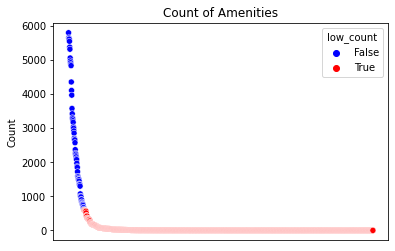

In [40]:
# Create a boolean series indicating whether the count is less than 400
amenities_count['low_count'] = amenities_count['count'] < 600

# Create a scatter plot with colored points
sns.scatterplot(x='amenity', y='count', data=amenities_count,
                hue='low_count', palette={False: 'blue', True: 'red'})

# Set labels and title
plt.xlabel('')
plt.ylabel('Count')
plt.title('Count of Amenities')

# Show only counts on y-axis
plt.gca().get_xaxis().set_visible(False)

# Show the plot
plt.show()


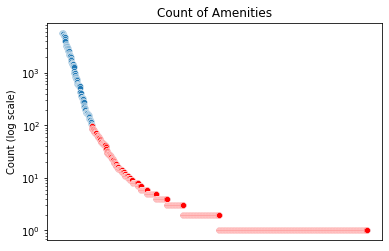

In [44]:
# create scatter plot
sns.scatterplot(x='amenity', y='count', data=amenities_count)

# set labels and title
plt.xlabel('')
plt.ylabel('Count (log scale)')
plt.title('Count of Amenities')

# show only counts on y-axis
plt.gca().get_xaxis().set_visible(False)

# set y-axis to logarithmic scale
plt.yscale('log')

# color points with count < 100 in red
sns.scatterplot(x='amenity', y='count', data=amenities_count[amenities_count['count'] < 100], color='red')

plt.show()

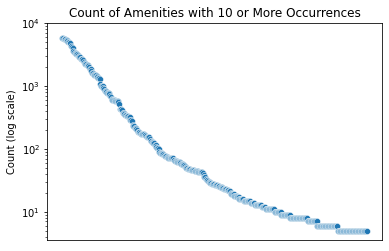

In [47]:
# Filter amenities_count by count >= 10
amenities_count_filtered = amenities_count[amenities_count['count'] >= 5]

# Create scatter plot with log scale for y-axis
sns.scatterplot(x='amenity', y='count', data=amenities_count_filtered)
plt.yscale('log')

# Set x-axis label and hide tick labels
plt.xlabel('Amenity')
plt.gca().get_xaxis().set_visible(False)

# Set y-axis label and log scale ticks
plt.ylabel('Count (log scale)')
plt.yticks([10, 100, 1000, 10000])

# Set plot title
plt.title('Count of Amenities with 10 or More Occurrences')

# Show the plot
plt.show()


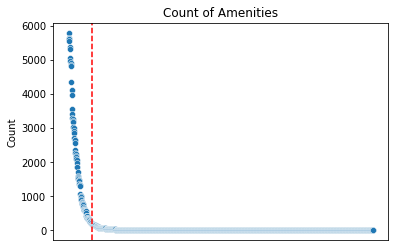

Cutoff index count: 182


In [54]:
# Get the x and y values from the scatter plot data
x = amenities_count.index.values
y = amenities_count['count'].values

# Create an array to store the distances
distances = np.zeros(len(x))

# Calculate the line segment joining the start point and end point
start_point = np.array([x[0], y[0]])
end_point = np.array([x[-1], y[-1]])
line_vec = end_point - start_point
line_len = np.linalg.norm(line_vec)
line_unit_vec = line_vec / line_len

# Calculate the distances of each point to the line segment
for i in range(len(x)):
    point_vec = np.array([x[i], y[i]]) - start_point
    proj_vec = np.dot(point_vec, line_unit_vec) * line_unit_vec
    dist_vec = point_vec - proj_vec
    dist = np.linalg.norm(dist_vec)
    distances[i] = dist

# Find the index of the point with the maximum distance
cutoff_index = np.argmax(distances)

# Plot the scatter plot with the elbow point marked

sns.scatterplot(x='amenity', y='count', data=amenities_count)
plt.axvline(x[cutoff_index], color='red', linestyle='--')

# show only counts on y-axis
plt.gca().get_xaxis().set_visible(False)

plt.xlabel('Amenity')
plt.ylabel('Count')
plt.title('Count of Amenities')
plt.show()

print("Cutoff index count:", y[cutoff_index])


In [52]:
amenities_count[amenities_count['count'] > 182].shape[0]

101